# Project:  Traffic Sign Classification 
**In this project, We used Python and TensorFlow to classify traffic signs.**

**Dataset used: [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
This dataset has more than 50,000 images of 43 classes.**

**We were able to reach a 94.61% testing accuracy.**

In [1]:
!pip install kaggle

In [2]:
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"babloobabloo","key":"35f3d115d3ffd19d2ae2bb9d9c37cfb2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change permission
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
#!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 600M/612M [00:25<00:00, 23.9MB/s]
100% 612M/612M [00:25<00:00, 25.2MB/s]


In [10]:
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  inflating: train/5/00005_00054_00001.png  
  in

In [11]:
import tensorflow as tf
from tensorflow import keras 
from PIL import Image, ImageOps
import cv2 
import random
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt

from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
from tqdm import tqdm
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix


#Loading train data(just used as a reference when using train data and splitting it)
---

In [12]:
df = pd.read_csv("Train.csv")
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)  #for train


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [14]:
for i, row in df.iterrows():
    print(row['Path'])

Streaming output truncated to the last 5000 lines.
Train/35/00035_00000_00011.png
Train/35/00035_00000_00012.png
Train/35/00035_00000_00013.png
Train/35/00035_00000_00014.png
Train/35/00035_00000_00015.png
Train/35/00035_00000_00016.png
Train/35/00035_00000_00017.png
Train/35/00035_00000_00018.png
Train/35/00035_00000_00019.png
Train/35/00035_00000_00020.png
Train/35/00035_00000_00021.png
Train/35/00035_00000_00022.png
Train/35/00035_00000_00023.png
Train/35/00035_00000_00024.png
Train/35/00035_00000_00025.png
Train/35/00035_00000_00026.png
Train/35/00035_00000_00027.png
Train/35/00035_00000_00028.png
Train/35/00035_00000_00029.png
Train/35/00035_00001_00000.png
Train/35/00035_00001_00001.png
Train/35/00035_00001_00002.png
Train/35/00035_00001_00003.png
Train/35/00035_00001_00004.png
Train/35/00035_00001_00005.png
Train/35/00035_00001_00006.png
Train/35/00035_00001_00007.png
Train/35/00035_00001_00008.png
Train/35/00035_00001_00009.png
Train/35/00035_00001_00010.png
Train/35/00035_0000

In [15]:
data=[]
labels=[]


In [16]:
for i,row  in tqdm(df.iterrows()):
    
    # image path
    image = Image.open(row['Path'])

    #resize the image to a 30x30 :
    image=image.resize((30,30))

    #turn the image into a numpy array
    image=np.array(image)
    

    # Normalize the image
    #normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

    # Load the image into the array
    data.append(image)
    labels.append(row['ClassId'])
    

39209it [00:25, 1508.29it/s]


In [17]:
data = np.array(data)
data.shape  

(39209, 30, 30, 3)

In [18]:
labels=np.array(labels)
labels.shape

(39209,)

#testing the data with original test data
---
## Load The Data

In [19]:
df_new = pd.read_csv("Test.csv")
data_new = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

In [20]:
df_new.head()   

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [21]:
for i, row in df_new.iterrows():
    print(row['Path'])

Streaming output truncated to the last 5000 lines.
Test/07631.png
Test/07632.png
Test/07633.png
Test/07634.png
Test/07635.png
Test/07636.png
Test/07637.png
Test/07638.png
Test/07639.png
Test/07640.png
Test/07641.png
Test/07642.png
Test/07643.png
Test/07644.png
Test/07645.png
Test/07646.png
Test/07647.png
Test/07648.png
Test/07649.png
Test/07650.png
Test/07651.png
Test/07652.png
Test/07653.png
Test/07654.png
Test/07655.png
Test/07656.png
Test/07657.png
Test/07658.png
Test/07659.png
Test/07660.png
Test/07661.png
Test/07662.png
Test/07663.png
Test/07664.png
Test/07665.png
Test/07666.png
Test/07667.png
Test/07668.png
Test/07669.png
Test/07670.png
Test/07671.png
Test/07672.png
Test/07673.png
Test/07674.png
Test/07675.png
Test/07676.png
Test/07677.png
Test/07678.png
Test/07679.png
Test/07680.png
Test/07681.png
Test/07682.png
Test/07683.png
Test/07684.png
Test/07685.png
Test/07686.png
Test/07687.png
Test/07688.png
Test/07689.png
Test/07690.png
Test/07691.png
Test/07692.png
Test/07693.png
Test

In [22]:
data_new=[]
labels_new=[]

In [23]:
for i,row  in tqdm(df_new.iterrows()):
    
    # Replace this with the path to your image
    image_new = Image.open(row['Path'])

    #resize the image to a 30x30 with the same strategy as in TM2:
    image_new=image_new.resize((30,30))

    #turn the image into a numpy array
    #image_new=np.array(image_new)
    image_new = np.asarray(image_new, dtype=np.uint8)
    
    #converting the array into integers
    #image_new = image_new.astype('uint8')

    # Normalize the image
    #normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

    # Load the image into the array
    data_new.append(image_new)
    labels_new.append(row['ClassId'])
    

12630it [00:08, 1532.47it/s]


In [24]:
data_new = np.array(data_new)
data_new.shape  

(12630, 30, 30, 3)

In [25]:
labels_new=np.array(labels_new)
labels_new.shape

(12630,)

In [26]:
X_train_new = data
y_train_new = labels
X_test_new = data_new
y_test_new = labels_new

In [27]:
print(X_train_new.shape,y_train_new.shape,X_test_new.shape,y_test_new.shape)

(39209, 30, 30, 3) (39209,) (12630, 30, 30, 3) (12630,)


## **Grayscaling**:This is used to improve test accuracy

In [28]:
#converting to grayscale


def list_images(data,labels, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(data))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(data[indx].shape) == 2 else cmap
        plt.imshow(data[indx], cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

## **Grayscaling** the train data

In [29]:
 def gray_scale(data):                                              #train data
    """                                                            
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(data, cv2.COLOR_RGB2GRAY)

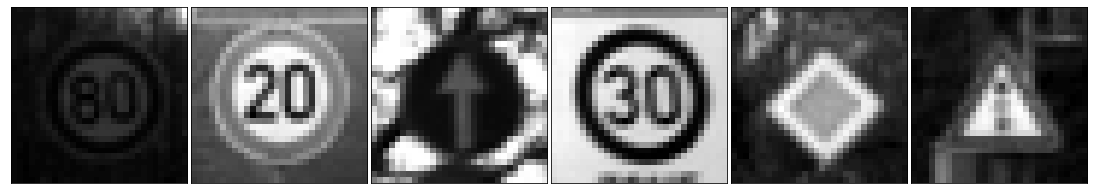

In [30]:
# Sample images after grayscaling
gray_images = list(map(gray_scale, X_train_new))
list_images(gray_images, y_train_new, "Gray Scale image", "gray")


In [31]:
g_img = np.array(gray_images)

In [32]:
g_img = g_img.reshape(39209,30,30,1)

In [33]:
#



def list_images_new(data_new,labels_new, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(data_new))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(data_new[indx].shape) == 2 else cmap
        plt.imshow(data_new[indx], cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

## **Grayscaling** the test data

In [34]:

def gray_scale_new(data_new):                                              
    
    return cv2.cvtColor(data_new, cv2.COLOR_RGB2GRAY)



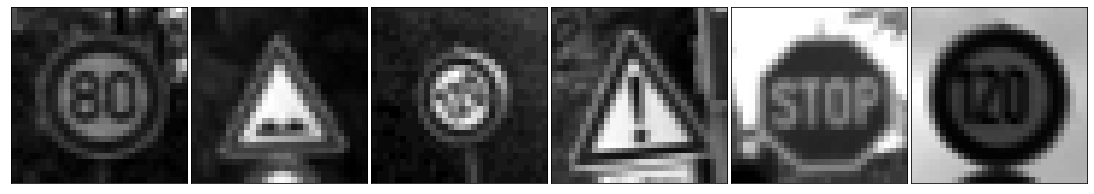

In [35]:
# Sample images after grayscaling
gray_images_new = list(map(gray_scale_new, X_test_new))
list_images_new(gray_images_new, y_test_new, "Gray Scale image", "gray")

In [36]:
g_img_new = np.array(gray_images_new)

In [37]:
g_img_new = g_img_new.reshape(12630,30,30,1)

## Creating the model

In [38]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation ='relu'))
    model.add(MaxPool2D(pool_size = (2,2) ))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation ='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation ='relu'))
    model.add(MaxPool2D(pool_size = (2,2) ))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation = 'softmax'))
    model.summary()
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    return model
    

In [39]:
input_shape = g_img[0].shape


## Fitting the model

In [40]:
#model.callback
model_path = 'traffic_sign_model_grayscale_2'
epochs = 50
batch_size =256

model = get_conv_model()
es = EarlyStopping(monitor = 'val_loss', verbose =1, mode =min, patience = 3)  
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', verbose = 1, mode='min',
                             save_best_only=True, save_weights_only = False, period =1)
history = model.fit(g_img, y_train_new, batch_size=batch_size, shuffle = True, 
                    epochs= epochs, 
                    verbose = 1, validation_data=(g_img_new,y_test_new), callbacks = [checkpoint])

model.save(model_path)         

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0

## Getting the final test score(ie Accuracy score)

In [41]:
#y_class
yp=[]
print(y_test_new)
#for k in range(y_test_new.shape[0]):
#    for j in range(y_test_new.shape[1]):
#        if y_test_new[k][j]==1:
#            yy.append(j)

model=load_model(model_path)
y_pred = model.predict(g_img_new)
print(y_pred.shape)

for i in y_pred:
    vec=list(i)
    yp.append(vec.index(max(vec)))
        
#print(yp)
#print(len(y_test))

from sklearn.metrics import accuracy_score

print('Accuracy score : ', accuracy_score(y_test_new,yp))

from sklearn.metrics import confusion_matrix

c = confusion_matrix(y_test_new,yp)
print(c)

from sklearn.metrics import classification_report
target_names = []
for i in range(43):
    target_names.append('class '+str(i))
print((classification_report(y_test_new,yp,target_names = target_names)))


[16  1 38 ...  6  7 10]
(12630, 43)
Accuracy score :  0.9667458432304038
[[ 60   0   0 ...   0   0   0]
 [  0 714   2 ...   0   0   0]
 [  0   2 740 ...   0   0   0]
 ...
 [  0   2   1 ...  81   0   4]
 [  0   0   0 ...   0  41   0]
 [  0   0   0 ...   0   0  89]]
              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99        60
     class 1       0.95      0.99      0.97       720
     class 2       0.99      0.99      0.99       750
     class 3       0.96      0.96      0.96       450
     class 4       0.99      0.97      0.98       660
     class 5       0.97      0.96      0.97       630
     class 6       0.99      0.91      0.95       150
     class 7       0.99      0.98      0.99       450
     class 8       0.97      0.98      0.98       450
     class 9       0.96      1.00      0.98       480
    class 10       1.00      0.99      1.00       660
    class 11       0.95      0.91      0.93       420
    class 12       0.97      0.9

## Displaying the confusion matrix

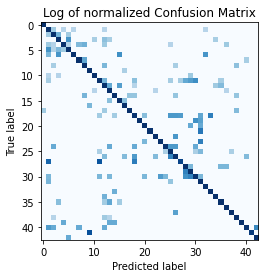

In [42]:
cm = confusion_matrix(y_test_new, yp)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [43]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5332607462354222852, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14703747524639797248
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17560015833894861033
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11146722048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4426357402456694654
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]